In [1]:
!pip3 install vaderSentiment

     |████████████████████████████████| 133kB 3.4MB/s 


In [2]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline,FeatureUnion
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.metrics import plot_roc_curve
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor,AdaBoostRegressor,BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from nltk.cluster import KMeansClusterer,cosine_distance, euclidean_distance
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.regularizers import l2
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping,CSVLogger

In [3]:
!pip3 install spacy-transformers

     |████████████████████████████████| 61kB 2.3MB/s 
     |████████████████████████████████| 10.0MB 6.6MB/s 
     |████████████████████████████████| 573kB 60.5MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
     |████████████████████████████████| 245kB 60.9MB/s 
     |████████████████████████████████| 2.1MB 38.1MB/s 
     |████████████████████████████████| 890kB 61.7MB/s 
     |████████████████████████████████| 133kB 60.5MB/s 
     |████████████████████████████████| 3.7MB 58.5MB/s 
     |████████████████████████████████| 1.1MB 68.3MB/s 
     |████████████████████████████████| 6.8MB 59.4MB/s 
     |████████████████████████████████| 71kB 9.9MB/s 
  Created wheel for torchcontrib: filename=torchcontrib-0.0.2-cp36-none-any.whl size=7533 sha256=11714a94048f8b0c4787e363a66fffe025923d5b0df05c9ccc34babe8202a867
  Stored in directory: /root/.cache/pip/wheels/06/06/7b/a5f5920bbf4f12a2c927e438fac17d4cd9560f8336b00e9a99
  Created wheel for ftfy: filename=ftfy-5.8-cp36-none-any.whl si

In [4]:
!python3 -m spacy download en_trf_bertbaseuncased_lg

     |████████████████████████████████| 405.8MB 1.1MB/s 
  Created wheel for en-trf-bertbaseuncased-lg: filename=en_trf_bertbaseuncased_lg-2.3.0-cp36-none-any.whl size=405808565 sha256=6057b03e3cd41be901fc8f9e75ece48b953d4f6bc8785de9cf64dcc2cd2faa4b
  Stored in directory: /tmp/pip-ephem-wheel-cache-ls3fpabq/wheels/34/31/e9/a65093916b43098517a3f131d614b0b215b33186ca6577e74d
Successfully built en-trf-bertbaseuncased-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_trf_bertbaseuncased_lg')


In [5]:
import spacy
import pandas as pd

In [6]:
nlp=spacy.load('/usr/local/lib/python3.6/dist-packages/en_trf_bertbaseuncased_lg/en_trf_bertbaseuncased_lg-2.3.0')

Let's test it to see if it's working well.

In [7]:
apple1 = nlp("Apple shares rose on the news.")
apple2 = nlp("Apple sold fewer iPhones this quarter.")
apple3 = nlp("Apple pie is delicious.")
print(apple1[0].similarity(apple2[0]))  # 0.73428553
print(apple1[0].similarity(apple3[0]))  # 0.43365782

0.73428565
0.43365785


In [9]:
reviews_ratings=pd.read_csv('/content/drive/My Drive/amazon_reviews_project/reviews_and_ratings.csv')

In [10]:
reviews_ratings.head(2)

,overall,reviewText
0,1,I was a huge fan when the Divergent series sta...
1,4,Excellent read.


In [11]:
reviews_ratings.shape

(5535445, 2)

In [12]:
#Let's just take the first 10_000 rows to test for feasibility.
reviews_ratings_selection=reviews_ratings.loc[:1_000_000]

In [13]:
reviews_ratings.dropna(inplace=True)

In [14]:
#parameters for tokenization
max_len=200
training_samples=600_000
validation_samples=100_000
max_words=10_000

In [15]:
#instantiate the tokenizer
tokenizer=Tokenizer(num_words=max_words)

In [16]:
text_data=reviews_ratings_selection['reviewText'].astype('str')

In [46]:
#instantiate instance of Vader sentiment analyzer
sentiment=SentimentIntensityAnalyzer()
#using vader sentiment analyzer for a second input
df=pd.DataFrame(text_data)
#df['polarity']=sentiment.polarity_scores(df['reviewText'][:200])
df_polarity=pd.DataFrame([sentiment.polarity_scores(df.loc[:,'reviewText'][i][:200]) for i in range(len(df))])

In [47]:
df_polarity

,neg,neu,pos,compound
0,0.038,0.709,0.253,0.7935
1,0.000,0.213,0.787,0.5719
2,0.058,0.733,0.209,0.6542
3,0.000,0.675,0.325,0.9098
4,0.062,0.740,0.198,0.7054
...,...,...,...,...
999996,0.000,0.858,0.142,0.6310
999997,0.688,0.312,0.000,-0.2960
999998,0.058,0.720,0.222,0.8398
999999,0.000,1.000,0.000,0.0000


In [49]:
#fit the tokenizer
tokenizer.fit_on_texts(text_data)

In [50]:
#create the sequences
sequences=tokenizer.texts_to_sequences(text_data)

In [51]:
#pad sequences
data=pad_sequences(sequences,maxlen=max_len) #to be able to handle docs too small to feed.

In [52]:
#y is rating (here referred to as 'overall')
y=reviews_ratings_selection['overall']

In [61]:
#create train/test sets
X_train=data[:training_samples]
df_polarity_train=df_polarity[:training_samples]
X_test=data[training_samples:training_samples+validation_samples]
df_polarity_test=df_polarity[training_samples:training_samples+validation_samples]

y_train=y[:training_samples]
y_train_categorical=tf.keras.utils.to_categorical(y_train)[:,1:]  #dropping first column
y_train_categorical[:4]
y_test=y[training_samples:training_samples+validation_samples]
y_test_categorical=tf.keras.utils.to_categorical(y_test)[:,1:]  #dropping first column
y_test_categorical[:100]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0.

In [62]:
y_test[90:100]

600090    5
600091    5
600092    5
600093    5
600094    4
600095    5
600096    4
600097    3
600098    5
600099    5
Name: overall, dtype: int64

Thus, ratings 1,2,3,4,5 correspond to labels 0,1,2,3,4 respectively.

In [63]:
#simple network model
#model=Sequential()
#model.add(Dense(64,activation='relu'))
#model.add(Dense(1,activation='linear'))

In [81]:
input_A = keras.layers.Input(shape=(200, ))
input_B = keras.layers.Input(shape=(4, ))
batch_normalization=keras.layers.BatchNormalization()(input_A)
hidden1=keras.layers.Dense(400,activation='relu',kernel_regularizer=l2(0))(batch_normalization)
hidden2=keras.layers.Dense(3200,activation='relu',kernel_regularizer=l2(0))(hidden1)
hidden3=keras.layers.Dense(6400,activation='relu',kernel_regularizer=l2(0))(hidden2)
hidden4=keras.layers.Dense(1600,activation='relu',kernel_regularizer=l2(0))(hidden3)
hidden5=keras.layers.Dense(400,activation='relu',kernel_regularizer=l2(0))(hidden4)
hidden6=keras.layers.Dense(200,activation='relu',kernel_regularizer=l2(0))(hidden5)
hidden7=keras.layers.Dense(200,activation='relu',kernel_regularizer=l2(0))(hidden6)
hidden8=keras.layers.Dense(100,activation='relu',kernel_regularizer=l2(0))(hidden7)
hidden9=keras.layers.Dense(100,activation='relu',kernel_regularizer=l2(0))(hidden8)
hidden10=keras.layers.Dense(50,activation='relu',kernel_regularizer=l2(0))(hidden9)
hidden11=keras.layers.Dense(25,activation='relu',kernel_regularizer=l2(0))(hidden10)
concat=keras.layers.concatenate([hidden1,hidden2,hidden3,hidden4,hidden5,hidden11])
hidden12=keras.layers.Dense(25,activation='relu',kernel_regularizer=l2(0))(concat)
concat2=keras.layers.concatenate([hidden12,input_B])
hidden13=keras.layers.Dense(25,activation='relu',kernel_regularizer=l2(0))(concat2)
hidden14=keras.layers.Dense(50,activation='relu',kernel_regularizer=l2(0))(hidden13)
hidden15=keras.layers.Dense(25,activation='relu',kernel_regularizer=l2(0))(hidden14)
output=keras.layers.Dense(5,activation='softmax')(hidden15)

model=keras.models.Model(inputs=[input_A,input_B], outputs=[output])

In [82]:
#add a callback
callback=EarlyStopping(monitor='loss',patience=5)

In [83]:
#compile
model.compile(
    loss='categorical_crossentropy',
    optimizer='Rmsprop', #'Adadelta',  #keras.optimizers.Adam(lr=0.00001),
    metrics=['accuracy'],
)

In [84]:
#Let's perform value_count on reviews_ratings_selection by 'overall'. This will help us compute appropriate class weights for each class.
reviews_ratings_selection['overall'].value_counts(normalize=True)

5    0.668561
4    0.180189
3    0.076424
1    0.038292
2    0.036534
Name: overall, dtype: float64

In [85]:
class_weight = {4: 1,
                3: 1,
                2: 1,
                0: 1,
                1: 1}

In [86]:
#fit
history=model.fit((X_train,df_polarity_train),y_train_categorical,batch_size=10000,class_weight=class_weight,validation_data=((X_test,df_polarity_test),y_test_categorical),epochs=200,callbacks=[callback],verbose=1)

Epoch 1/200
60/60 [==============================] - 102s 2s/step - loss: 1.1662 - accuracy: 0.6538 - val_loss: 1.0755 - val_accuracy: 0.6673
Epoch 2/200
60/60 [==============================] - 102s 2s/step - loss: 0.9966 - accuracy: 0.6724 - val_loss: 0.9994 - val_accuracy: 0.6670
Epoch 3/200
60/60 [==============================] - 101s 2s/step - loss: 0.9559 - accuracy: 0.6722 - val_loss: 0.9478 - val_accuracy: 0.6657
Epoch 4/200
60/60 [==============================] - 102s 2s/step - loss: 0.9321 - accuracy: 0.6721 - val_loss: 0.9382 - val_accuracy: 0.6680
Epoch 5/200
60/60 [==============================] - 104s 2s/step - loss: 0.9236 - accuracy: 0.6730 - val_loss: 0.9286 - val_accuracy: 0.6685
Epoch 6/200
60/60 [==============================] - 106s 2s/step - loss: 0.9170 - accuracy: 0.6738 - val_loss: 0.9286 - val_accuracy: 0.6683
Epoch 7/200
60/60 [==============================] - 106s 2s/step - loss: 0.9102 - accuracy: 0.6743 - val_loss: 0.9309 - val_accuracy: 0.6680
Epoch 

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],label='Train accuracy')   #mae on training set
plt.plot(history.history['val_accuracy'],label='Validation accuracy');  #mae on validation set
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

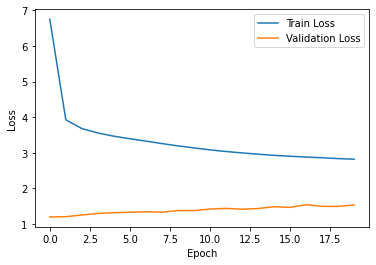

In [ ]:
plt.plot(history.history['loss'],label='Train Loss')   #mae on training set
plt.plot(history.history['val_loss'],label='Validation Loss');  #mae on validation set
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [ ]:
preds=model.predict(X_test)

In [ ]:
plt.plot(y_test,preds)

In [ ]:
pd.DataFrame(preds).value_counts()

In [ ]:
pd.DataFrame(y_test).describe()